# Straightened video created using registration

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.io import loadmat
from IPython.display import HTML

from otimage import imagerep, readers
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

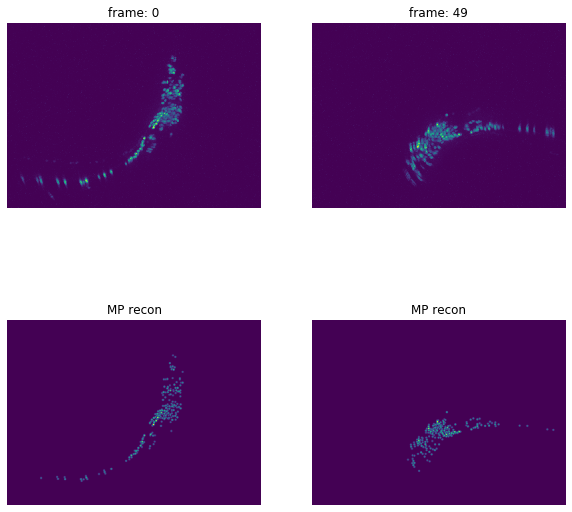

In [3]:
# Frames to load
t_start = 0
n_frames = 50
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img = [reader.get_frame(t) for t in t_vals]
    img_shape = img[0].shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts = [mp_data['means'][t, :, :] for t in t_vals]
wts = [mp_data['weights'][t, :, 0] for t in t_vals]

# Reconstruct images from MPs
mp_img = [imagerep.reconstruct_image(pts[i], [cov], wts[i], img_shape) for i in range(n_frames)]

# Indices to plot
k1 = 0
k2 = -1
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img[k1])
plt.title(f'frame: {t_vals[k1]}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img[k2])
plt.title(f'frame: {t_vals[k2]}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(mp_img[k1])
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(mp_img[k2])
plt.title('MP recon')
plt.axis('off');

## Compute registrations for images

### Choose registration method

In [4]:
reg = partial(ot_registration, degree=3, n_iter=50)

### Register all frames to first frame

In [5]:
models = [None] * (n_frames - 1)
debug = [None] * (n_frames - 1)

# Compute mapping from nth frame to first frame
for t in range(n_frames - 1):
    models[t], debug[t] = reg(pts[t + 1], pts[0], wts[t + 1], wts[0])

### Reconstruct frames using mappings learned using both methods

In [6]:
rec = [mp_img[0]] + [None] * (n_frames - 1)

for t in range(1, n_frames):
    
    pb_pts = models[t - 1].predict(pts[t])
    rec[t] = imagerep.reconstruct_image_2(pb_pts, wts[t], cov, img_shape)

### Plot single frame next to reconstruction

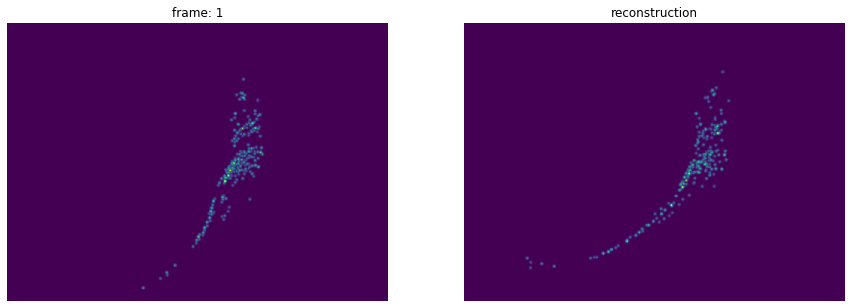

In [7]:
t = 1

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj(mp_img[t])
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj(rec[t])
plt.title(f'reconstruction')
plt.axis('off');

### Create video of all frame reconstructions

In [8]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 15))

ax_1.set_title('frame: 0')
ax_2.set_title('straightened')

ax_1.axis('off')
ax_2.axis('off')

def animate(t):
    
    ax_1.set_title(f'frame: {t}')
    
    plot_maxproj(mp_img[t], ax=ax_1, animated=True)
    plot_maxproj(rec[t], ax=ax_2, animated=True)
    
ani = animation.FuncAnimation(fig, animate, n_frames)
ani.save('video_straight_ot.mp4')

# Prevent double-display of animation
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())